In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import root_mean_squared_error
import cvxpy as cp
from hyperopt import fmin, tpe, hp, Trials
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# time series plot
# causal graph

# hyper-params vary by channel
# MLFlow

# validate model

# response curves

# calibration

# budget optimisation

# seasonality
# trend

# Import data

In [3]:
df = pd.read_csv("mmm_training_data.csv")
df['week_ending'] = pd.to_datetime(df['week_ending'])
df = df.sort_values(by=["week_ending"]).reset_index(drop=True)
df

,week_ending,spend_ppc_nb,spend_ppc_b,spend_social,imp_ppc_nb,imp_ppc_b,imp_social,clk_ppc_nb,clk_ppc_b,clk_social,imp_seo,clk_seo,demand,conversions
0,2021-01-03,5249.82,8892.61,23654.36,3841530,8483,3213265,30387,4083,10547,181049,11751,72,1989
1,2021-01-10,6559.41,14710.67,51764.77,5420719,18277,5141459,42216,8688,15238,149213,10177,71,1807
2,2021-01-17,4480.64,15685.86,54968.74,3494441,17614,4522178,28825,7966,14145,143316,10403,73,1833
3,2021-01-24,3566.58,18022.25,52360.92,3183709,19794,4349616,30769,8855,12718,149786,11043,75,1921
4,2021-01-31,13171.17,19528.00,147908.35,2778447,21906,10410231,20068,9264,22942,173740,12672,71,2341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2024-04-28,106030.07,21209.89,53475.76,200121,32170,14768637,4633,13937,30539,621504,55942,81,2247
174,2024-05-05,137776.76,21601.90,52552.17,268167,35102,15388683,7767,15484,29904,667976,60592,78,2688
175,2024-05-12,78721.38,17308.82,56726.01,226918,33357,18650946,6159,15072,27541,656537,55458,72,2058
176,2024-05-19,60470.16,17172.98,47983.05,178135,31592,10310526,3709,14775,14892,623004,54486,76,1729


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   week_ending   178 non-null    datetime64[ns]
 1   spend_ppc_nb  178 non-null    float64       
 2   spend_ppc_b   178 non-null    float64       
 3   spend_social  178 non-null    float64       
 4   imp_ppc_nb    178 non-null    int64         
 5   imp_ppc_b     178 non-null    int64         
 6   imp_social    178 non-null    int64         
 7   clk_ppc_nb    178 non-null    int64         
 8   clk_ppc_b     178 non-null    int64         
 9   clk_social    178 non-null    int64         
 10  imp_seo       178 non-null    int64         
 11  clk_seo       178 non-null    int64         
 12  demand        178 non-null    int64         
 13  conversions   178 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(10)
memory usage: 19.6 KB


In [5]:
# set date column
date_col = "week_ending"

# set features
features = ["spend_ppc_nb",
            "spend_ppc_b",
            "spend_social",
            "imp_seo",
            "demand",
]

# set target
target = "conversions"

# retrieve features and target
X = df[features].values
y = df[target].values

## EDA

### Time-series analysis

In [6]:
# scale data first?

### Bi-variate analysis

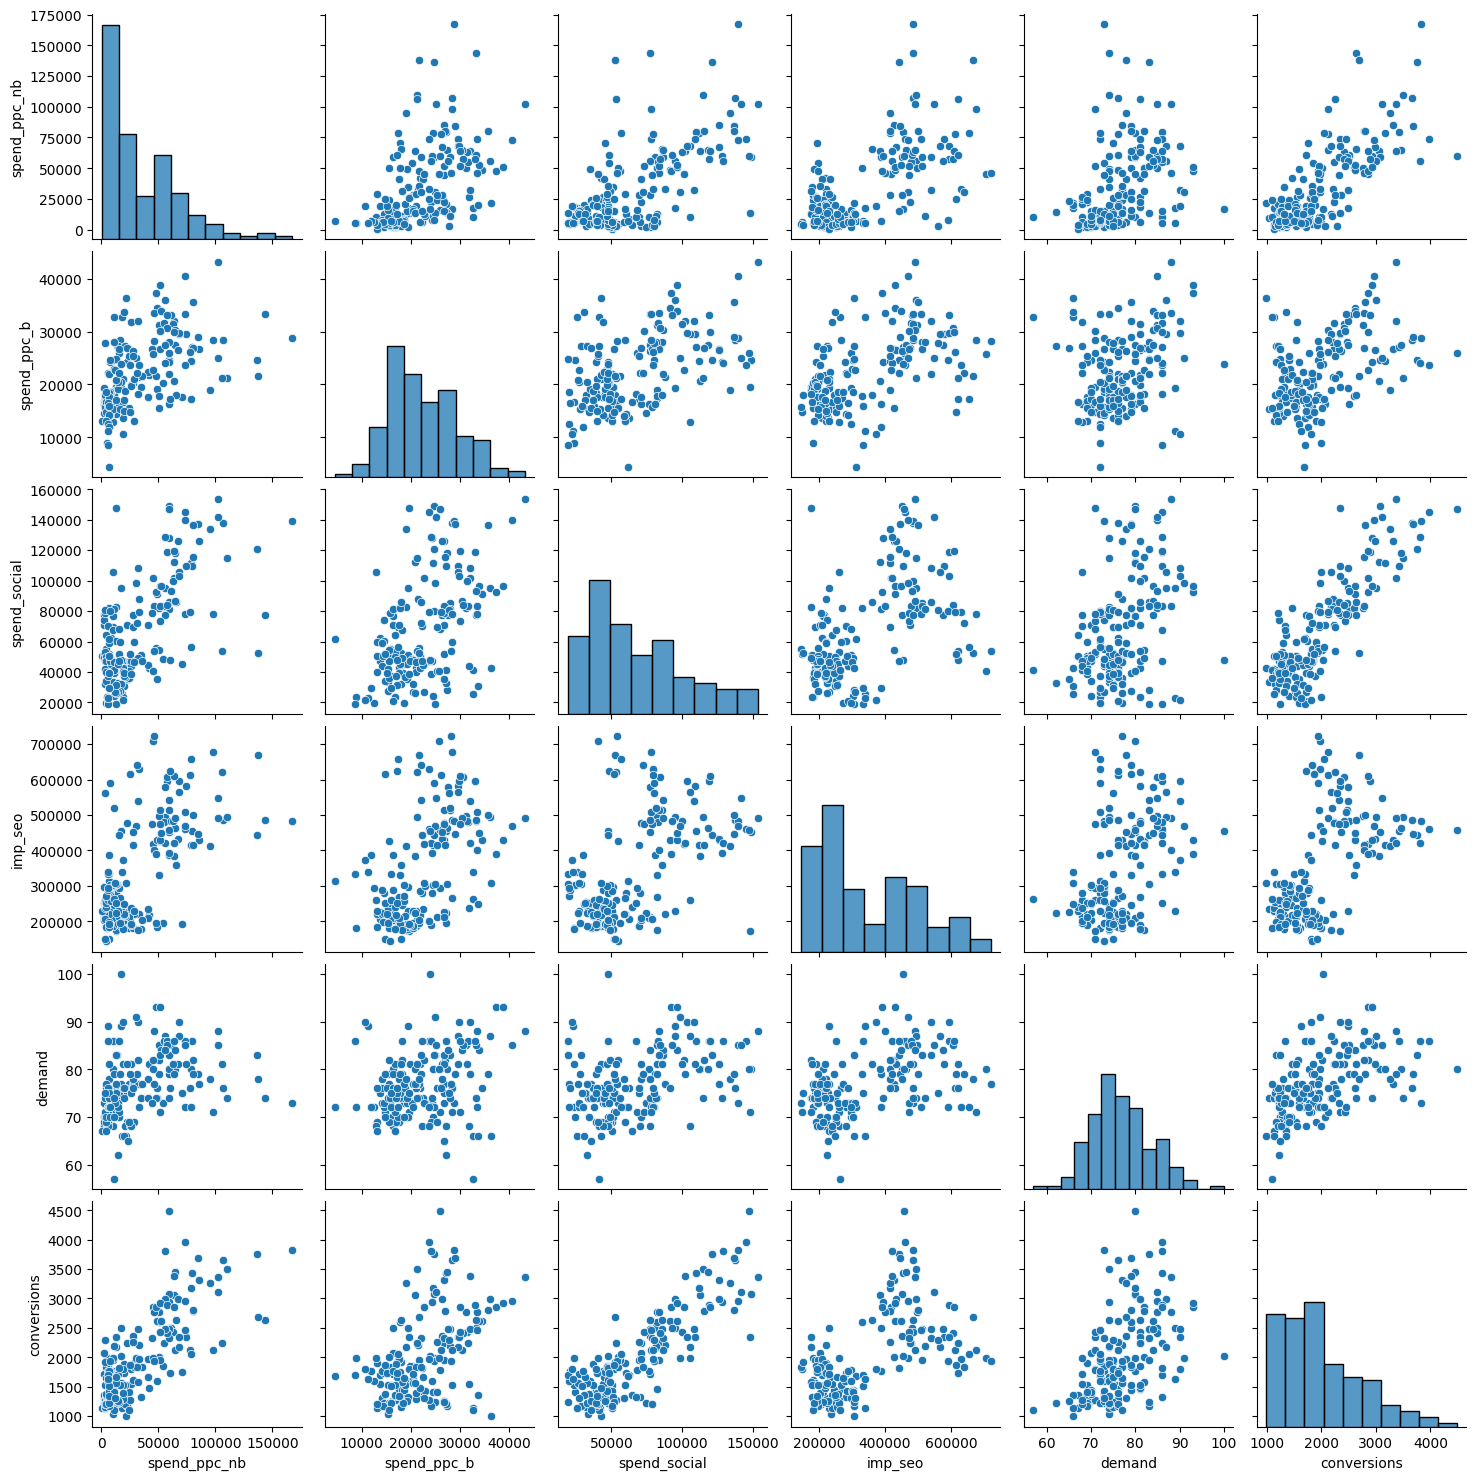

In [7]:
sns.pairplot(df[features + [target]])

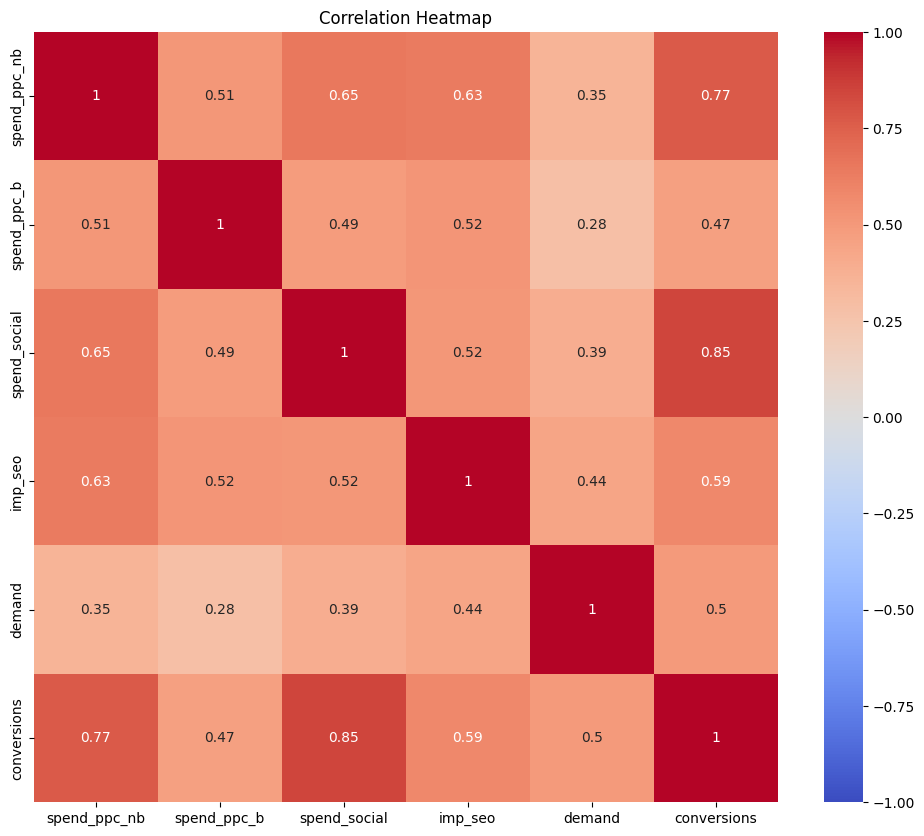

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [9]:
vif_data = pd.DataFrame()
vif_data['feature'] = features
vif_data['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
vif_data

,feature,VIF
0,spend_ppc_nb,4.818451
1,spend_ppc_b,17.292766
2,spend_social,9.613691
3,imp_seo,12.750672
4,demand,16.439006


### Causal graph

# Pre-processing

### Train/test indexs

In [10]:
# set train/test params
burn_in_obs = 4
out_of_time_obs = 8

# calculate indexs
train_idx = slice(burn_in_obs, len(df) - out_of_time_obs)
out_of_time_idx = slice(len(df) - out_of_time_obs, len(df))

### Set coefficient signs

In [11]:
# set coefficient signs
positive_indices = np.array([1, 2, 3, 4, 5])
negative_indices = np.array([])

# Transformations

### Carryover

In [12]:
def transform_adstock(X, adstock_decay):
    adstocked = np.zeros_like(X)
    adstocked[0, :] = X[0, :]
    for t in range(1, X.shape[0]):
        adstocked[t, :] = X[t, :] + adstock_decay * adstocked[t - 1, :]
    return adstocked

In [ ]:
n_samples, n_channels = X.shape
adstocked = np.zeros_like(X)

def transform_adstock(X, adstock_decay):
  
for i in range(n_channels):
    decay = adstock_decay[i]
    adstocked_channel = np.zeros(n_samples)
    adstocked_channel[0] = X[0, i]
    for t in range(1, n_samples):
        adstocked_channel[t] = X[t, i] + decay * adstocked_channel[t - 1]
    adstocked[:, i] = adstocked_channel
    
return adstocked

### Saturation

In [13]:
def transform_logistic(X, logistic_lam):
    return (1 - np.exp(-logistic_lam * X)) / (1 + np.exp(-logistic_lam * X))

### Scale features

In [14]:
def fit_feature_scaler(X):
    return MaxAbsScaler().fit(X)

In [15]:
def apply_feature_scaler(transformer, X):
    return transformer.transform(X)

### Add intercept

In [16]:
def add_intercept(X):
    intercept = np.ones((X.shape[0], 1))
    return np.hstack((intercept, X))

# Train model

### Train model

In [17]:
def train_model(X, y, reg_alpha, positive_indices, negative_indices):
    coef = cp.Variable(X.shape[1])
    ridge_penalty = cp.norm(coef, 2)
    objective = cp.Minimize(cp.sum_squares(X @ coef - y) + reg_alpha * ridge_penalty)
    constraints = [coef[i] >= 0 for i in positive_indices] + [coef[i] <= 0 for i in negative_indices]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    print(problem.status)
    return coef.value 

In [18]:
def predict(X, optimized_coef):
    return X @ optimized_coef

In [19]:
def rmse(y_true, y_pred):
    return round(root_mean_squared_error(y_true, y_pred), 2)

### Hyper-parameter tuning

In [20]:
def objective(params):
    
    X_adstocked = transform_adstock(X=X, 
                                    adstock_decay=params["adstock_decay"])
    
    X_saturated = transform_logistic(X=X_adstocked, 
                                     logistic_lam=params["logistic_lam"])
    
    X_train = X_saturated[train_idx]
    y_train = y[train_idx]
    
    transformer = fit_feature_scaler(X_train)
    X_train_scaled = apply_feature_scaler(transformer, X_train)
    X_train_scaled_intercept = add_intercept(X_train_scaled)
    
    optimized_coef = train_model(X=X_train_scaled_intercept, 
                                 y=y_train, 
                                 reg_alpha=params["reg_alpha"], 
                                 positive_indices=positive_indices, 
                                 negative_indices=negative_indices)
    
    train_predictions = predict(X_train_scaled_intercept, optimized_coef)
    train_rmse = rmse(y_train, train_predictions)
    
    return train_rmse

space = {
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'adstock_decay': hp.uniform('adstock_decay', 0.0, 0.5),
    'logistic_lam': hp.uniform('logistic_lam', 1e-6, 1e-3)
}

trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

print("Best parameters found: ", best)

optimal                                                
optimal                                                
  1%|          | 1/100 [00:00<00:06, 16.44trial/s, best loss: 595.46]

optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                              
optimal                                                               
optimal                                                               
optimal                                                               
optimal                                                               
optimal                                                               
optimal        

### Final model

In [21]:
best

{'adstock_decay': 0.4186225782483167,
 'logistic_lam': 1.3419328190925968e-06,
 'reg_alpha': 0.842268470264075}

In [22]:
X_adstocked = transform_adstock(X=X, 
                                adstock_decay=best["adstock_decay"])
    
X_saturated = transform_logistic(X=X_adstocked, 
                                logistic_lam=best["logistic_lam"])
    
X_train = X_saturated[train_idx]
X_test = X_saturated[out_of_time_idx]
y_train = y[train_idx]
y_test = y[out_of_time_idx]
    
transformer = fit_feature_scaler(X_train)
X_train_scaled = apply_feature_scaler(transformer, X_train)
X_test_scaled = apply_feature_scaler(transformer, X_test)
    
X_train_scaled_intercept = add_intercept(X_train_scaled)
X_test_scaled_intercept = add_intercept(X_test_scaled)
    
optimized_coef = train_model(X=X_train_scaled_intercept, 
                             y=y_train, 
                             reg_alpha=best["reg_alpha"], 
                             positive_indices=positive_indices, 
                             negative_indices=negative_indices)

optimal


In [23]:
optimized_coef

array([-3.06376724e+02,  1.32140741e+03,  1.21905303e-07,  1.77456322e+03,
        7.06075415e-06,  1.39964219e+03])

# Validate model

### Model fit

In [24]:
train_predictions = predict(X_train_scaled_intercept, optimized_coef)
test_predictions = predict(X_test_scaled_intercept, optimized_coef)
train_rmse = rmse(y_train, train_predictions)
test_rmse = rmse(y_test, test_predictions)

In [25]:
# actual vs predicted chart including model fit metrics

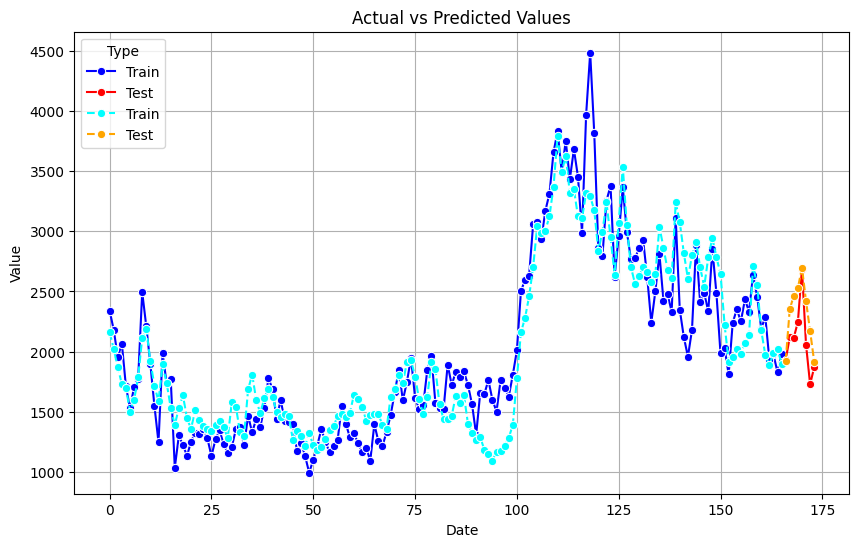

In [26]:
df_train = pd.DataFrame({
    'Actual': y_train,
    'Predicted': train_predictions,
    'Type': 'Train'
})

df_test = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Type': 'Test'
})

df = pd.concat([df_train, df_test])
df["Index"] = range(len(df))

# Plot using seaborn
plt.figure(figsize=(10, 6))

# Plot actual values
sns.lineplot(x='Index', y='Actual', hue='Type', data=df, marker='o', palette={'Train': 'blue', 'Test': 'red'})

# Plot predicted values
sns.lineplot(x='Index', y='Predicted', hue='Type', data=df, linestyle='--', marker='o', palette={'Train': 'cyan', 'Test': 'orange'})

# Formatting
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend(title='Type', loc='upper left')
plt.grid(True)
plt.show()

### Model diagnostics

In [27]:
# look at nixtla

### Feature contributions

In [28]:
def calculate_contributions(X, optimized_coef):
    return X * optimized_coef.reshape(1, -1)

In [29]:
train_contributions = calculate_contributions(X_train_scaled_intercept, optimized_coef)

In [30]:
print(f'Intercept: {round(train_contributions[:, 0].sum() / train_predictions.sum(), 2)}')
print(f'Feature 1: {round(train_contributions[:, 1].sum() / train_predictions.sum(), 2)}')
print(f'Feature 2: {round(train_contributions[:, 2].sum() / train_predictions.sum(), 2)}')
print(f'Feature 3: {round(train_contributions[:, 3].sum() / train_predictions.sum(), 2)}')
print(f'Feature 4: {round(train_contributions[:, 4].sum() / train_predictions.sum(), 2)}')
print(f'Feature 5: {round(train_contributions[:, 5].sum() / train_predictions.sum(), 2)}')

Intercept: -0.15
Feature 1: 0.16
Feature 2: 0.0
Feature 3: 0.43
Feature 4: 0.0
Feature 5: 0.56


In [31]:
# contribution waterfall

In [32]:
# stack chart of contributions over time

# Response curves

### x

# Calibration

### x

# Budget optimisation

### x